# Time Series with LSTMs

Cassandra Maldonado

1. Import, clean and plot the input data.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import tensorflow as tf
import os

In [8]:
# Define the timeseries_train_test_split function
def timeseries_train_test_split(data, train_size):
	"""
	Splits time series data into training and testing sets.
	
	Parameters:
	- data: array-like, the time series data to split
	- train_size: int, the number of samples in the training set
	
	Returns:
	- train_data: array-like, the training data
	- test_data: array-like, the testing data
	"""
	train_data = data[:train_size]
	test_data = data[train_size:]
	return train_data, test_data

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
def import_and_clean_data(filename='DAYTON_hourly.csv'):
    df = pd.read_csv(filename)
    
    # Datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    # Index
    df.set_index('Datetime', inplace=True)
    
    # Checking for missing values
    print(f"Missing values: {df.isna().sum()}")
    
    # Time series plot
    plt.figure(figsize=(14, 6))
    plt.plot(df['DAYTON_MW'])
    plt.title('Dayton Power Consumption (MW)')
    plt.xlabel('Date')
    plt.ylabel('Power (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df

# LSTM sequence
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# LSTM model
def build_and_train_lstm(X_train, y_train, X_test, y_test, bidirectional=False, epochs=50, batch_size=32):
    # Reshape input data for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    model = Sequential()
    
    if bidirectional:
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
    else:
        model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    
    # Training 
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    )
    
    # Predicting
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # RMSE
    train_rmse = np.sqrt(np.mean((train_predictions - y_train) ** 2))
    test_rmse = np.sqrt(np.mean((test_predictions - y_test) ** 2))
    
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    
    return model, history, test_predictions, test_rmse

# Model predictions
def plot_predictions(y_test, predictions, title):
    plt.figure(figsize=(14, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Power (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # 1. Import and clean the data
    df = import_and_clean_data()
    
    # Extract the target column
    data = df['DAYTON_MW'].values


2. Train test split (use provided helper function helper.py Download helper.py, as we can’t use sklearn’s for time series data).

Missing values: DAYTON_MW    0
dtype: int64


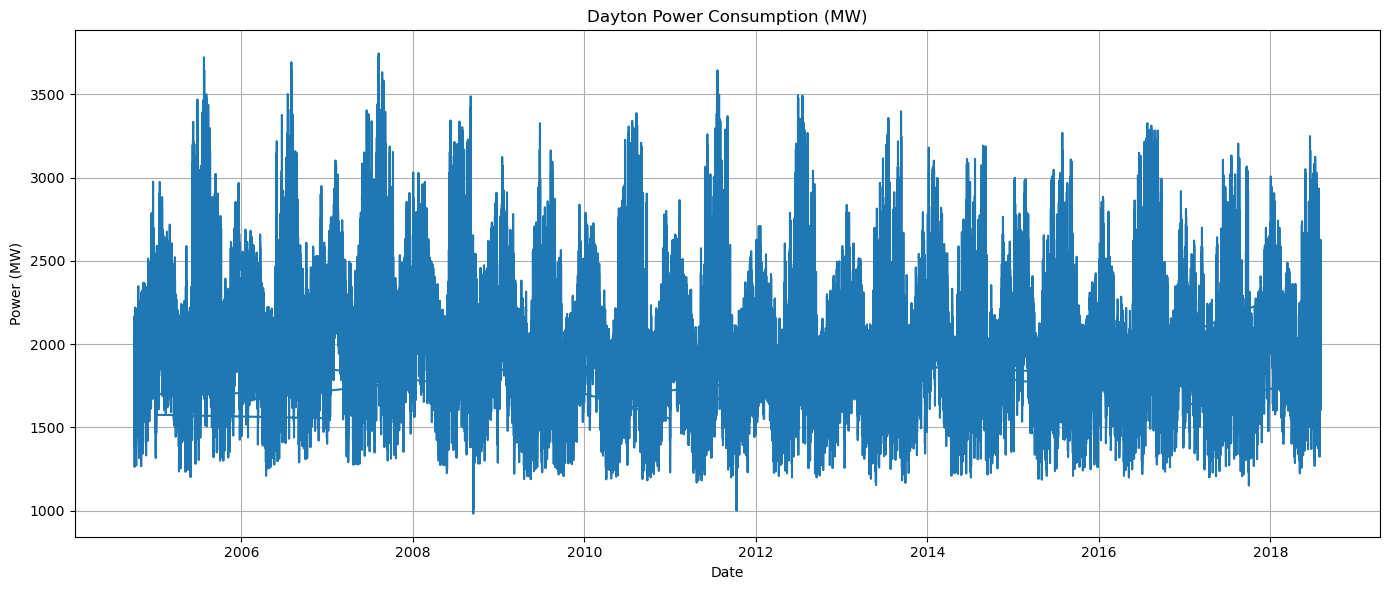

Training data size: 97020
Testing data size: 24255


In [12]:
# Extract the target column from the dataframe
df = import_and_clean_data()  # Ensure the data is imported and cleaned
data = df['DAYTON_MW'].values

train_size = int(len(data) * 0.8)
train_data, test_data = timeseries_train_test_split(data, train_size)
	
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

3. Fit a single layer LSTM with lag = 3 hours.

In [13]:
print("Single Layer LSTM with lag = 3 hours")
lag_3 = 3
X_train_3, y_train_3 = create_sequences(train_data, lag_3)
X_test_3, y_test_3 = create_sequences(test_data, lag_3)
    
model_3, history_3, predictions_3, rmse_3 = build_and_train_lstm(
    X_train_3, y_train_3, X_test_3, y_test_3
)
    
plot_predictions(y_test_3, predictions_3, 'Single Layer LSTM (lag=3) Predictions')

Single Layer LSTM with lag = 3 hours
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 628us/step - loss: 318907.7500 - val_loss: 8747.2871
Epoch 2/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step - loss: 10397.2705 - val_loss: 9119.9307
Epoch 3/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step - loss: 8650.7656 - val_loss: 6072.4644
Epoch 4/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 587us/step - loss: 6824.8154 - val_loss: 5419.7373
Epoch 5/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 597us/step - loss: 5713.6562 - val_loss: 5385.7930
Epoch 6/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 586us/step - loss: 5644.6240 - val_loss: 5420.2695
Epoch 7/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step - loss: 5589.5068 - val_loss: 5418.5649
Epoch 8/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 591us/step - loss: 5565.4873 - val_loss: 5532.8364
Epoch 9/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 590us/step - loss: 5541.8027 - val_loss: 5466.4390
Epoch 10/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 589us/step - loss: 5519.1777 - val_loss: 5422.8149
Epoch 11/50
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 2s 5

: 

4. Fit a single layer LSTM with lag = 24 hours.

In [ ]:
print("Single Layer LSTM with lag = 24 hours")
lag_24 = 24
X_train_24, y_train_24 = create_sequences(train_data, lag_24)
X_test_24, y_test_24 = create_sequences(test_data, lag_24)
    
model_24, history_24, predictions_24, rmse_24 = build_and_train_lstm(
    X_train_24, y_train_24, X_test_24, y_test_24
)
    
plot_predictions(y_test_24, predictions_24, 'Single Layer LSTM (lag=24) Predictions')

5. Fit a bidirectional LSTM with lag = 24 hours.

In [ ]:
print("\n=== Bidirectional LSTM with lag = 24 hours ===")
model_bi, history_bi, predictions_bi, rmse_bi = build_and_train_lstm(
    X_train_24, y_train_24, X_test_24, y_test_24, bidirectional=True
)
    
plot_predictions(y_test_24, predictions_bi, 'Bidirectional LSTM (lag=24) Predictions')

6. Plot results on test set and compare performance using RMSE.

In [ ]:
print("\n=== Performance Comparison (RMSE) ===")
print(f"Single Layer LSTM (lag=3): {rmse_3:.2f}")
print(f"Single Layer LSTM (lag=24): {rmse_24:.2f}")
print(f"Bidirectional LSTM (lag=24): {rmse_bi:.2f}")
    
# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(y_test_24, label='Actual')
plt.plot(predictions_24, label='Single Layer LSTM (lag=24)')
plt.plot(predictions_bi, label='Bidirectional LSTM (lag=24)')
plt.title('Model Comparison on Test Set')
plt.xlabel('Time Step')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if __name__ == "__main__":
    main()